# Setup

In [3]:
# download the MNIST dataset from mldata.org
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
# define alternative due to server issues at mldata.org
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

In [4]:
# print data
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [5]:
# analyse shape of data from MNIST
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


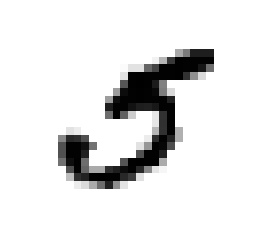

Label 5.0


In [6]:
# display a sample data
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
# transform the array data from 784 features to a 28x28 matrix
some_digit_image = some_digit.reshape(28, 28)

# cmap defines the black/white format
# interpolation defines the display "smothness" from one pixel to another
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation="nearest")
# disable the x and y axis
plt.axis("off")
plt.show()

print("Label", y[36000])

# Preprocessing

In [7]:
# split the test set before analysing the data further!
# MNIST already provides a train and test data splitting: <= 60000 training, 60000 - 70000 testing
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [8]:
# shuffle training data to guarantee that cross-validation contains all digits 
# Improtant: only shuffle data that doe not show time series dependencies!
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Simplified Binary Model
Try to detect between 5 and not 5 digits.

In [9]:
# setup train data for 5 digit
y_train_5 = (y_train == 5) # True for all 5s, False for all other digits
y_test_5 = (y_test == 5)

In [10]:
# use Stohastic Gradient Descent classifier for training
from sklearn.linear_model import SGDClassifier

# init seed with 42 to be able to reproduce the result later
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [11]:
sgd_clf.predict([some_digit]) # test one prediction with the digit 5 that we visualized above

array([ True], dtype=bool)

### Custom Cross-Validation

In [12]:
# implement own cross-validation for exercising the similar behavior as cross_val_score()
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

# use stratified k-folds to keep proportion on cross-validation set
skfolds = StratifiedKFold(n_splits=3, random_state=42)

# for each split k-fold, in this case k=3, use 2 for training and 1 for validating
for train_index, test_index in skfolds.split(X_train, y_train_5):
    # clone the trained model of the Stohastic Gradient Descent classifier
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    # define validation set within the train set
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    # retrain to train folds
    clone_clf.fit(X_train_folds, y_train_folds)
    # predict on test fold
    y_pred = clone_clf.predict(X_test_fold)
    # sum how many where correct
    n_correct = sum(y_pred == y_test_fold)
    # calculate percentage
    print(n_correct / len(y_pred))

0.96745
0.96415
0.92575


In [13]:
# re-write the cross-validation above using the cross_val_score
from sklearn.model_selection import cross_val_score
# use cross-validation k-fold = 3 and measure the accuracy in percent
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.96745,  0.96415,  0.92575])

In [14]:
# test the model by analysing a "Never5Classifier" - inverse classifier
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.91045,  0.9082 ,  0.9103 ])

### Conclusion
The accuracy is around 90%, which is exactly the ration of data classes, because 10% of the images are 5. This proves that accuracy is not the preferred performance measure. If the classifier always guasses that the number is not a 5, the results will provide exactly the given 90% accuracy.

IMPORTANT: Using scores works fine for regression, but is not good with classification!

# Measuring Classifier Accuracy

## Confusion Matrix

In [16]:
# an good alternative instead of using the scores we can retrieve the cross-validation predictions 
# and build a confusion matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

confusion_matrix(y_train_5, y_train_pred)

array([[52855,  1724],
       [ 1129,  4292]])

### Description
The confusion matrix is build as follows:
* each row represents the actual classes
* each column represents the made prediction
* the perfect classifier would have only non-zero values on the main diagonal (left top to right bottom)

In this case we have two classes, which can be described as positives and negatives. Now we can describe the matrix as follows:

 | Predicted Negative | Predicted Positive
--: | ------------ | ------------
Actual Negative | true negatives  | false positives
Actual Positive  | false negatives | true positives

One of the most important metrics that can be extracted above are called:
* Precision => accuracy of positive predictions
* Recall => sensitivity / true positive rate / ratio of positive instances that are correctly detected by a classifier

Precision = TP / (TP + FP)

Recall = TP / (TP + FN)


## Precision/Recall tradeoff

In [17]:
# now to get an intuitive understanding of the matrix, we can calculate the so called
# precision and the recall

# precision = TP / (TP + FP)
# recall = TP / (TP + FN)

# scikit-learn provides functions for precision and recall calculation
from sklearn.metrics import precision_score, recall_score

print("Precision:", precision_score(y_train_5, y_train_pred))
print("Recall:", recall_score(y_train_5, y_train_pred))

Precision: 0.713430851064
Recall: 0.791735842096


In [18]:
# to compare multiple models it is more convenient to compare a single value
# therefore the precision and recall can be represented by the F1 score, which is
# the harmonic mean of precision and recall, which gives more weight to lower values
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.75054647197691704

### Conclusion
The model is only 77% of the time right, when claiming a 5. And it can only recognize a 5 in 81% of the time.
Overall the mean quality is only about 79%, which is not a good result for this kind dataset and classification.

IMPORTANT: The F1 score may not always be a good comparison for a model, because there are cases where precision or recall may be more important on its own and have to be improved individually.
E.g.: A cancer detection system is more important in having 99% recall rate rather than high precision. It may be better to have false alerts that a doctor has to double check, instead of claiming that a patient is healthy and failing to start a treatment in time.

Both are not possible! There is a tradeoff between precision and recall.

In [19]:
# to visualize the tradeoff of precision and recall we can use the decision_function instead of predict returning
# scores instead of predictions
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([ -694182.08542818,  -234545.07230872, -1094670.84407872, ...,
        -377450.8764749 ,   101031.95179787,  -180762.2362329 ])

In [20]:
# calculate the precisions, recalls and thresholds to plot the tradeoff
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [21]:
# define the visualization plot
def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

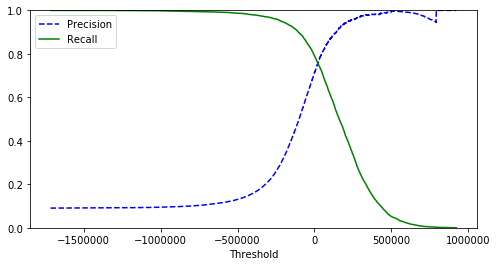

In [22]:
# call plot method
plt.figure(figsize=[8, 4])
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

### Conclusion
* You can improve on precision or recall but not both.
* The pricision has a small bump, because it can also decrease during when increasing.
* Recall looks smooth because it only can decrease over the score.

## Precision/Recall curve

In [23]:
# plot precision vs recall
def precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "g-")
    plt.ylabel("Precision")
    plt.xlabel("Recall")
    plt.ylim([0, 1])
    plt.xlim([0, 1])

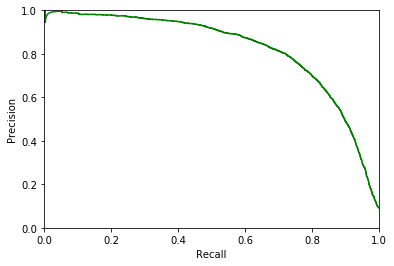

In [24]:
# show precision vs. recall plot
precision_vs_recall(precisions, recalls)
plt.show()

In [25]:
# to get a classifier with 90% score, simply use the threshold on the scores with a condition
y_train_pred_90 = (y_scores > 90000)

# to see the precision we can use the previous methods precision_score and recall_score
print("Precision:", precision_score(y_train_5, y_train_pred_90))
print("Recall:", recall_score(y_train_5, y_train_pred_90))

Precision: 0.856893106893
Recall: 0.632909057369


### Conclusion
Now in a naive approach if we want to have very high precission, we might tend to take a very high threshold and go nearly 100% precision regardless of the recall, BUT this without respect to the recall the classifier would rate almost everything as true!!!

One should always consider precision with respekt to the recall!

## ROC Curve
As an alternative we can use the receiver operating characteristic (ROC) curve, which uses true positive rate (FPR or another name for recall) and the false positive rate (FPR).
In other terms we plot sensitivity (recall) versus 1-specificity

In [26]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [27]:
# define plot function
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('Ture Positive Rate')

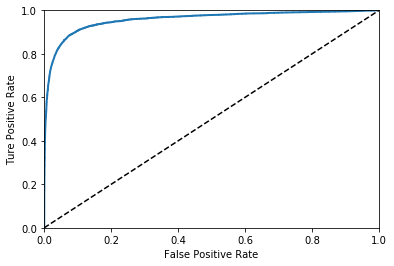

0.95772111957086237

In [28]:
# plot the ROC curve
plot_roc_curve(fpr, tpr)
plt.show()

# print ROC AUC score
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

### Conclusion
The ROC cureve plots the ratio between TPR and FPR and produces a curve whereas the area under the curve (AUC) and the dotted line must be maximized. The dotted line signals a totaly random classifier. Is is important to reach the top left corner finding good classifier.

=> perfect classifier has a AUC of 1

=> random classifier has a AUC of 0.5

### When to use Precision/Recall curve or ROC curve?
As a rule of thumb use Precision/Recall curve when focusing rather on false positive rate and the positive class is rare and otherwise use the ROC curve. 

As seen above the ROC curve might indicate that this is a good classifier, but the PR curve indicates that there is room for improvement!!!

## Train a RadomForestClassifier

In [29]:
# we are now trying to improve the Precision/Recall using a RandomForest classifier
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
# some classifiers do not provide a decision_function method but a dict_proba method due to their type of 
# classification -> to use the dict_proba, we parametrize the cross_val_predict with its predict_proba parameter
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

In [30]:
# to plot a ROC curve we need to transform the prbabilities to scores
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

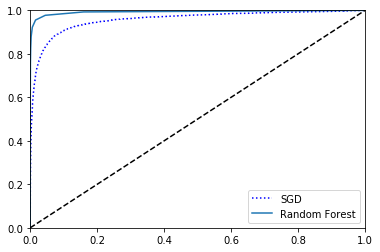

In [31]:
# plot the ROC curve
plt.plot(fpr, tpr, "b:", label="SGD")
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.legend(loc="lower right")
plt.show()

In [32]:
# see ROC AUC
roc_auc_score(y_train_5, y_scores_forest)

0.99272238678789626

In [33]:
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)

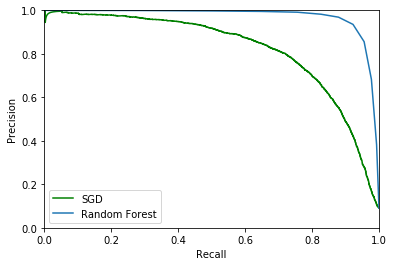

In [34]:
# compare precisions and recalls
plt.plot(recalls, precisions, "g-", label="SGD")
plt.plot(recalls_forest, precisions_forest, label="Random Forest")
plt.ylabel("Precision")
plt.xlabel("Recall")
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.legend(loc="lower left")
plt.show()

In [35]:
y_scores_forest

array([ 0. ,  0. ,  0. , ...,  0. ,  0.2,  0. ])

In [36]:
# use the cross-validation to receive the prediction values
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)

# to see the precision we can use the previous methods precision_score and recall_score
print("Precision:", precision_score(y_train_5, y_train_pred_forest))
print("Recall:", recall_score(y_train_5, y_train_pred_forest))

Precision: 0.98224852071
Recall: 0.826784726065


### Conclusion
The RandomForestClassifier shows a very high precision and recall rete clearly outperforming the previous SGDClassifier.

## Multilabel Classification

In [37]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [38]:
# make prediction
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

In [39]:
# evaluate classifier
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
#f1_score(y_train, y_train_knn_pred, average='macro')

In [40]:
# create un-equally scoring
#f1_score(y_train, y_train_knn_pred, average='weighted')

## Multioutput Classification

In [42]:
# create train data with distortion
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

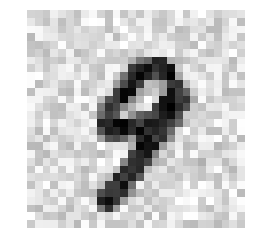

In [43]:
# show noisy image
some_digit_mod = X_train_mod[36000]
# transform the array data from 784 features to a 28x28 matrix
some_digit_image_mod = some_digit_mod.reshape(28, 28)

# cmap defines the black/white format
# interpolation defines the display "smothness" from one pixel to another
plt.imshow(some_digit_image_mod, cmap = matplotlib.cm.binary, interpolation="nearest")
# disable the x and y axis
plt.axis("off")
plt.show()

In [46]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

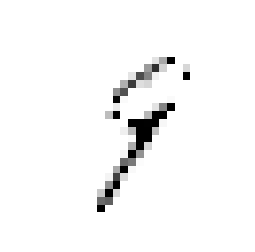

In [49]:
# train model to clean noise
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[9000]])
plot_digit(clean_digit)